In [1]:
%load_ext autoreload
%autoreload 2
#import torch
#import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sys
import json
import pandas as pd
from tqdm import tqdm
import os
from matplotlib.lines import Line2D
#sys.path.append('./utils/')

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

Training variables:
- For each electron : `pt, eta, dxy, dxySignif, PFRelIso, calRelIso, trkRelIso, numTrackerHits, trkChi2, trkProb`
- Jet/MET : `MET, jetMETdphi, minJetMETdPhi, met_leadPt_ratio, lead_jet_btag, lead_jet_pt, lead_jet_eta`
- Vertex : `sel_vtx_METdPhi, sel_vtx_chi2, sel_vtx_dR, sel_vtx_m, sel_vtx_minDxy, vxy, vxy_signif`

34 Total

In [2]:
base = "/uscms/home/sbrightt/nobackup/iDMe/neuralNet_study/MET170_trainSamples/"
sig = h5py.File(f"{base}/signal_noTruthMatch.h5","r")
bkg = h5py.File(f"{base}/bkg.h5","r")

dfs = pd.DataFrame({s:sig[s][()] for s in sig.keys() if s != 'sample'})
dfb = pd.DataFrame({s:bkg[s][()] for s in bkg.keys() if s != 'sample'})
dfs['samp'] = np.char.decode(sig['sample'][()])
dfb['samp'] = np.char.decode(bkg['sample'][()])

sigNames = list(set(dfs.samp))
bkgNames = list(set(dfb.samp))

sig.close()
bkg.close()

In [3]:
def yieldScan(df,thresholds):
    yields = []
    for t in thresholds:
        yields.append(np.sum(df[df.nnScore > t].wgt_norm))
    return np.array(yields)

# Neural net performance

In [4]:
thresholds = np.concatenate((np.arange(0.9,0.99,step=0.01),np.arange(0.99,1.0,step=0.001)))
bkg_yields = yieldScan(dfb,thresholds)
sig_yields = {}
for samp in sigNames:
    sig_yields[samp] = yieldScan(dfs[dfs.samp==samp],thresholds)

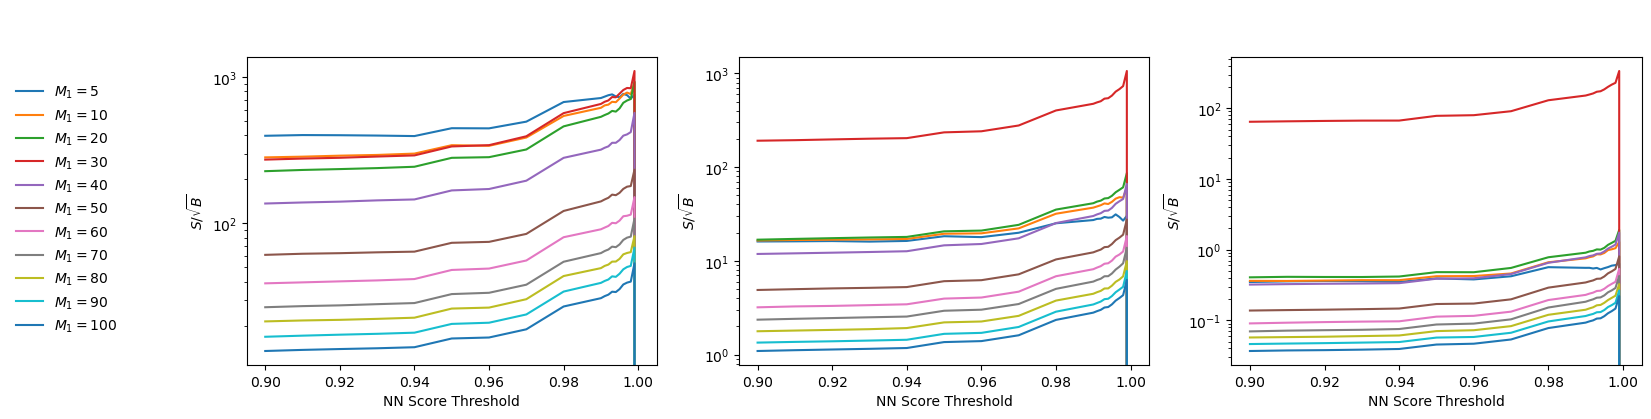

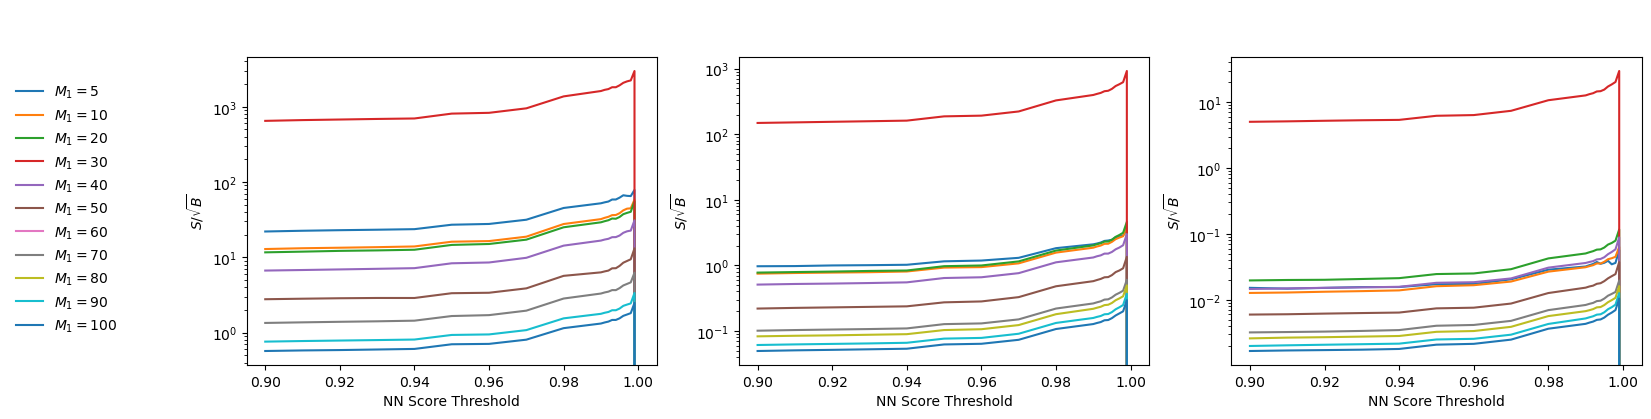

In [5]:
# plot signal significance
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields),where=bkg_yields!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields == 0)] = np.inf
            plt.plot(thresholds,signif,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.xlabel("NN Score Threshold")
        plt.ylabel("$S/\sqrt{B}$")
        plt.yscale('log')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

# Comparison to BDT (All $L_{xy}$)

In [6]:
from coffea import util

prefix = "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/studies/SR_BDT/BDT_Lxy/coffea/skimmed/"
suffix = '_LxyBDT-based_AllLxy'

bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}
bkg_histos = {}
for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]

sig_histo = util.load(f'{prefix}/LxyBDT-based_AllLxy.coffea')[0]

In [7]:
cut = 'cut10'
bdt_yield_bkg = 0
for b in bkg_histos.keys():
    cb = bkg_histos[b]['cutflow_cts']
    for b2 in cb.keys():
        bdt_yield_bkg += cb[b2][cut]

bdt_yields_sig = {}
for samp in sigNames:
    bdt_yields_sig[samp] = sig_histo['cutflow_cts'][samp][cut]

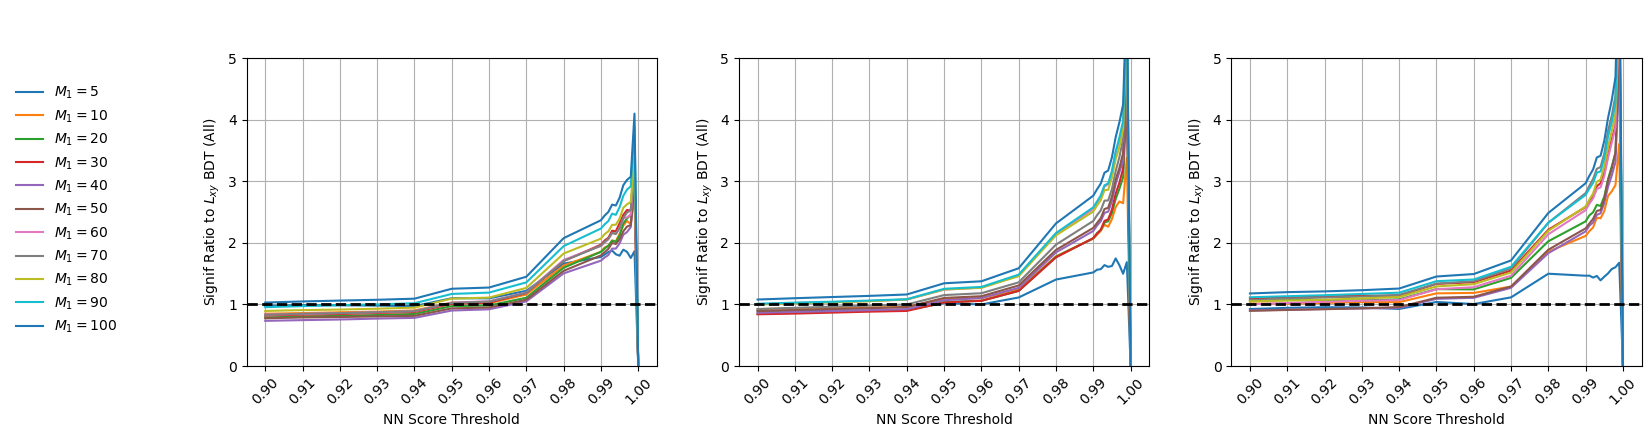

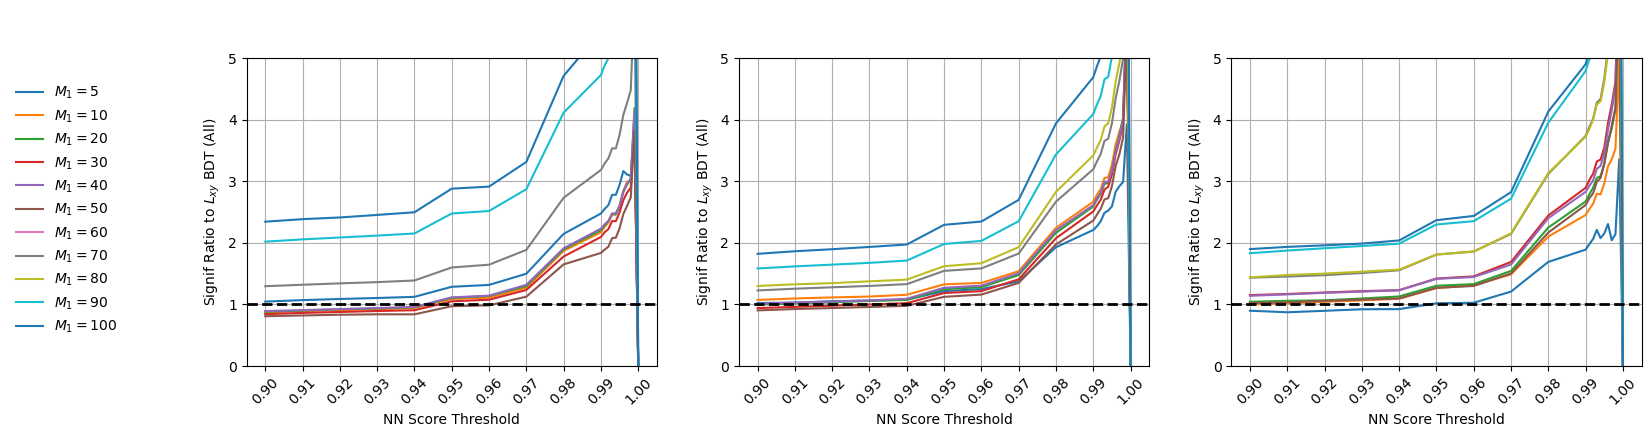

In [8]:
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields),where=bkg_yields!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields == 0)] = np.inf
            
            signif_bdt = bdt_yields_sig[sampName]/np.sqrt(bdt_yield_bkg)
            if signif_bdt == 0:
                signif_ratio = np.where(signif!=0,np.inf,0)
            else:
                signif_ratio = np.divide(signif,signif_bdt)
            plt.plot(thresholds,signif_ratio,color=massColors[m1])
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Signif Ratio to $L_{xy}$ BDT (All)")
        plt.axhline(1,lw=2,color='black',linestyle='--')
        #plt.yscale('log')
        plt.ylim([0,5])
        plt.yticks(np.arange(6))
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        plt.grid(axis='both')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

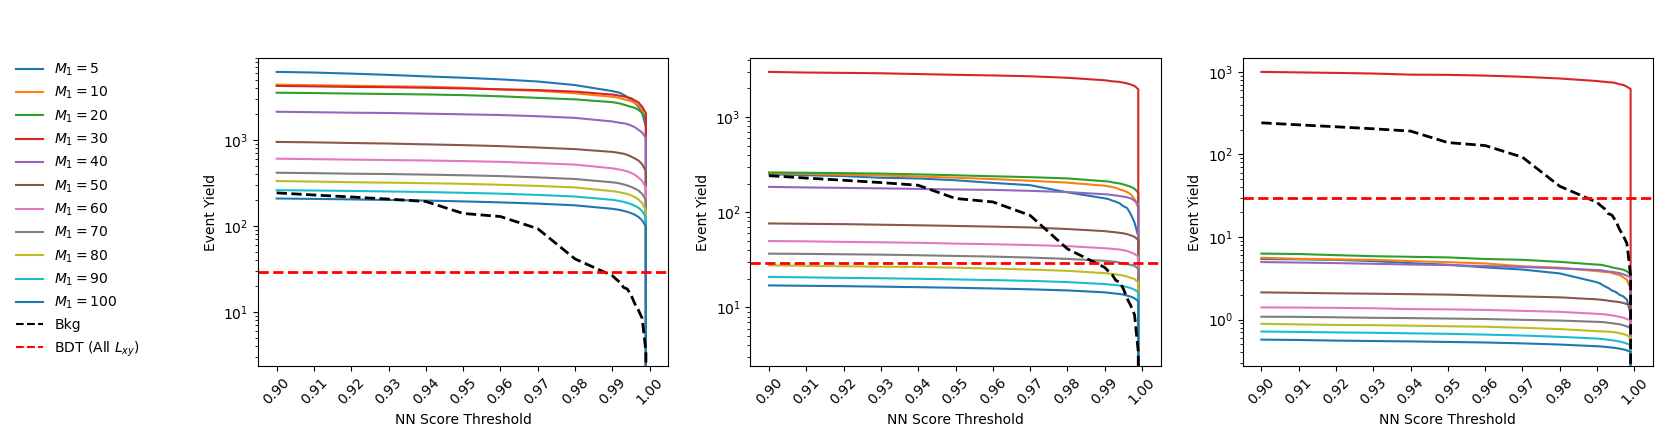

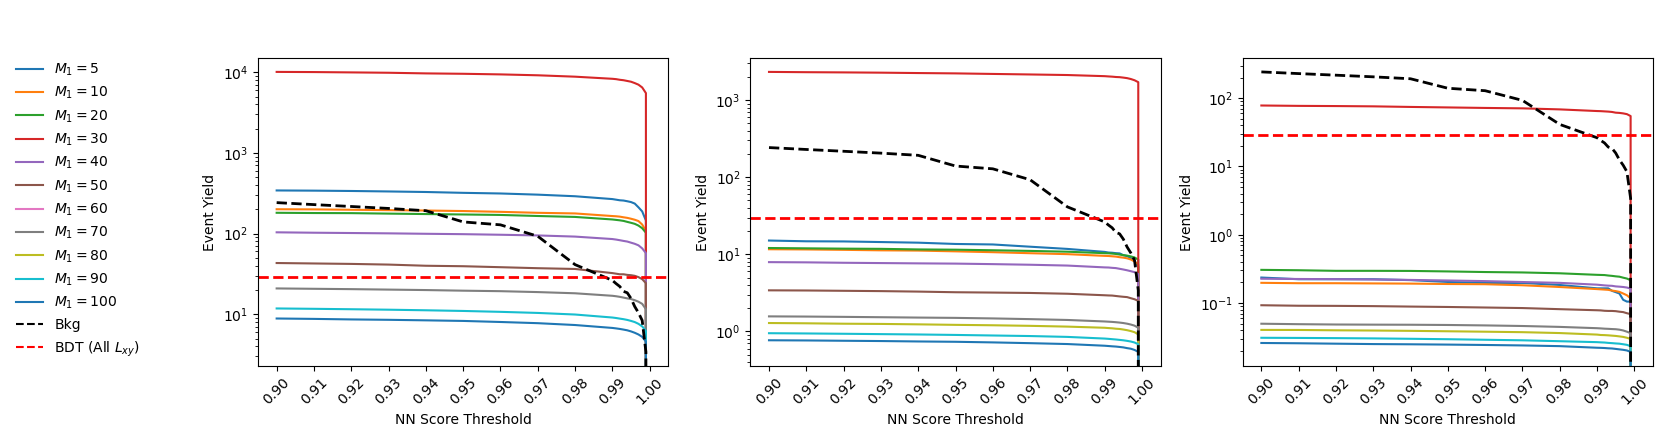

In [9]:
# plot event yields
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields[sampName]
            plt.plot(thresholds,y_sig,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.plot(thresholds,bkg_yields,color='black',lw=2,linestyle='--')
        plt.axhline(bdt_yield_bkg,color='red',lw=2,linestyle='--')
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Event Yield")
        plt.yscale('log')
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        
            
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))] + \
                 [Line2D([0], [0], label=f"Bkg", color='black',linestyle='--'), Line2D([0], [0], label="BDT (All $L_{xy}$)", color='red',linestyle='--')]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

# Low $L_{xy}$ bin ($L_{xy} < 0.5$ cm)

In [10]:
bkg_yields_lowLxy = yieldScan(dfb[dfb.vxy < 0.5],thresholds)
sig_yields_lowLxy = {}
for samp in sigNames:
    sig_yields_lowLxy[samp] = yieldScan(dfs[(dfs.samp==samp)&(dfs.vxy < 0.5)],thresholds)

## NN significance

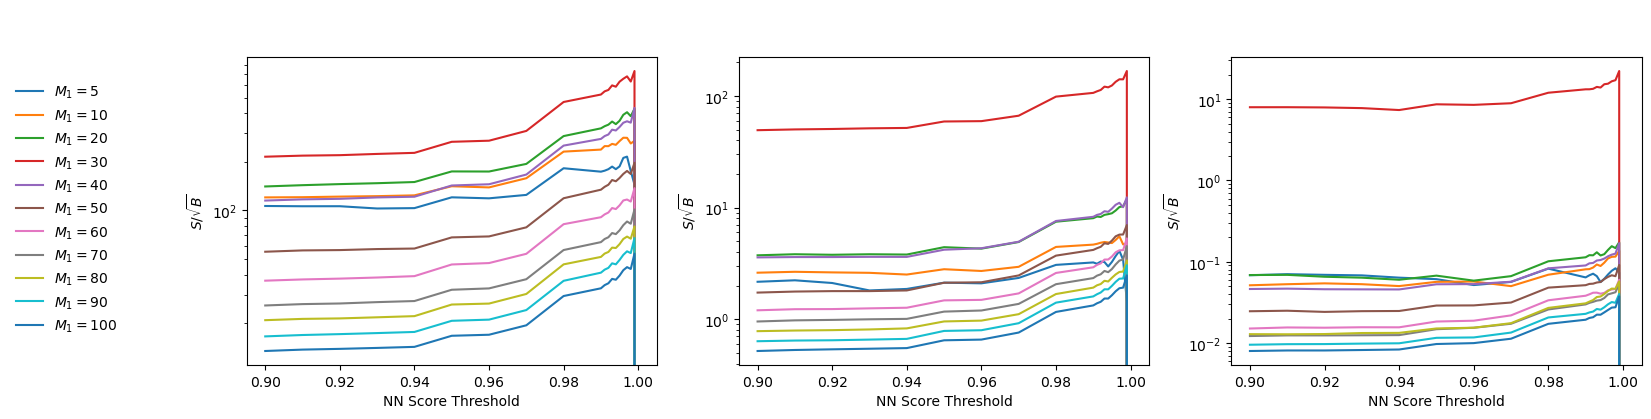

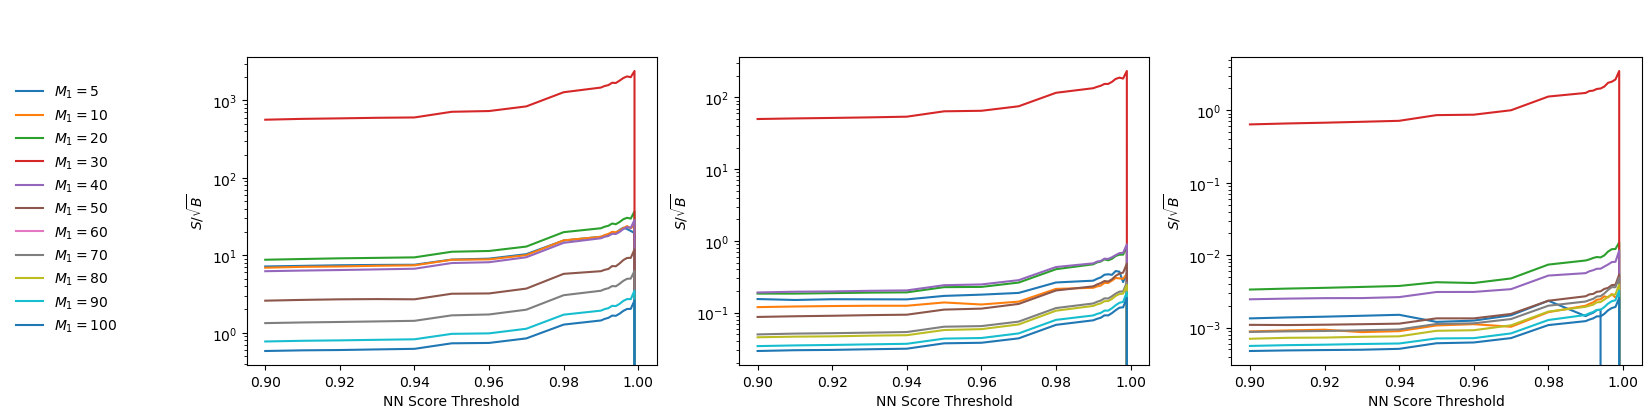

In [11]:
# plot signal significance
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_lowLxy[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields_lowLxy),where=bkg_yields_lowLxy!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields_lowLxy == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields_lowLxy == 0)] = np.inf
            plt.plot(thresholds,signif,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.xlabel("NN Score Threshold")
        plt.ylabel("$S/\sqrt{B}$")
        plt.yscale('log')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

In [12]:
prefix = "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/studies/SR_BDT/BDT_Lxy/coffea/skimmed/"
suffix = '_LxyBDT-based_LowLxy'

bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}
bkg_histos_lowLxy = {}
for b in bkg_files.keys():
    bkg_histos_lowLxy[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]

sig_histo_lowLxy = util.load(f'{prefix}/LxyBDT-based_LowLxy.coffea')[0]

In [13]:
cut = 'cut11'
bdt_yield_bkg_lowLxy = 0
for b in bkg_histos_lowLxy.keys():
    cb = bkg_histos_lowLxy[b]['cutflow_cts']
    for b2 in cb.keys():
        bdt_yield_bkg_lowLxy += cb[b2][cut]

bdt_yields_sig_lowLxy = {}
for samp in sigNames:
    bdt_yields_sig_lowLxy[samp] = sig_histo_lowLxy['cutflow_cts'][samp][cut]

## NN vs BDT significance

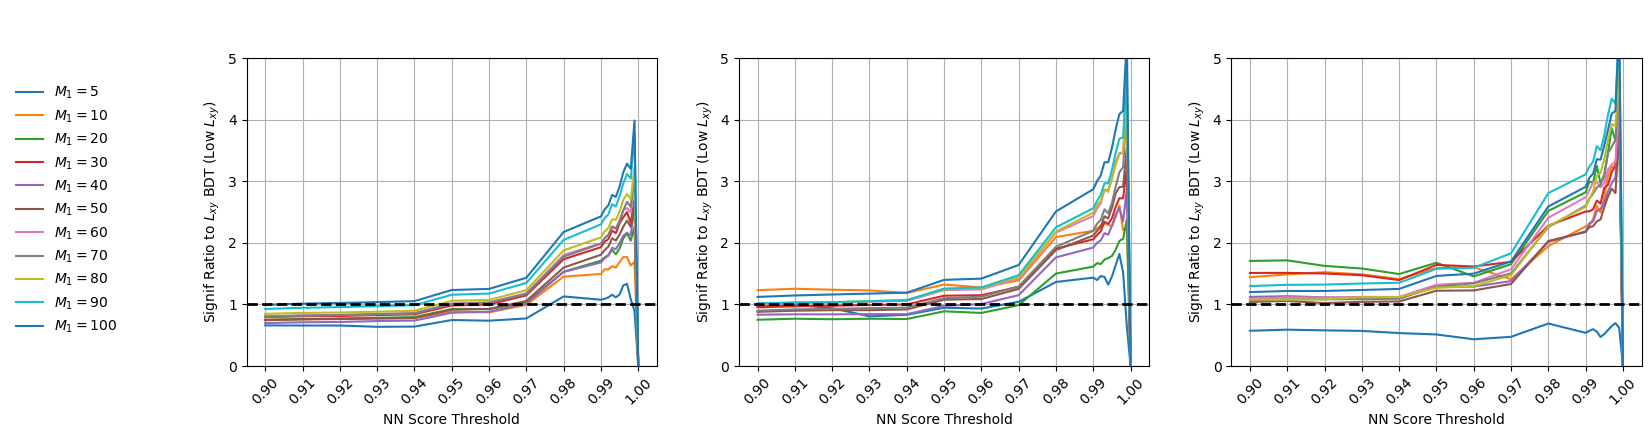

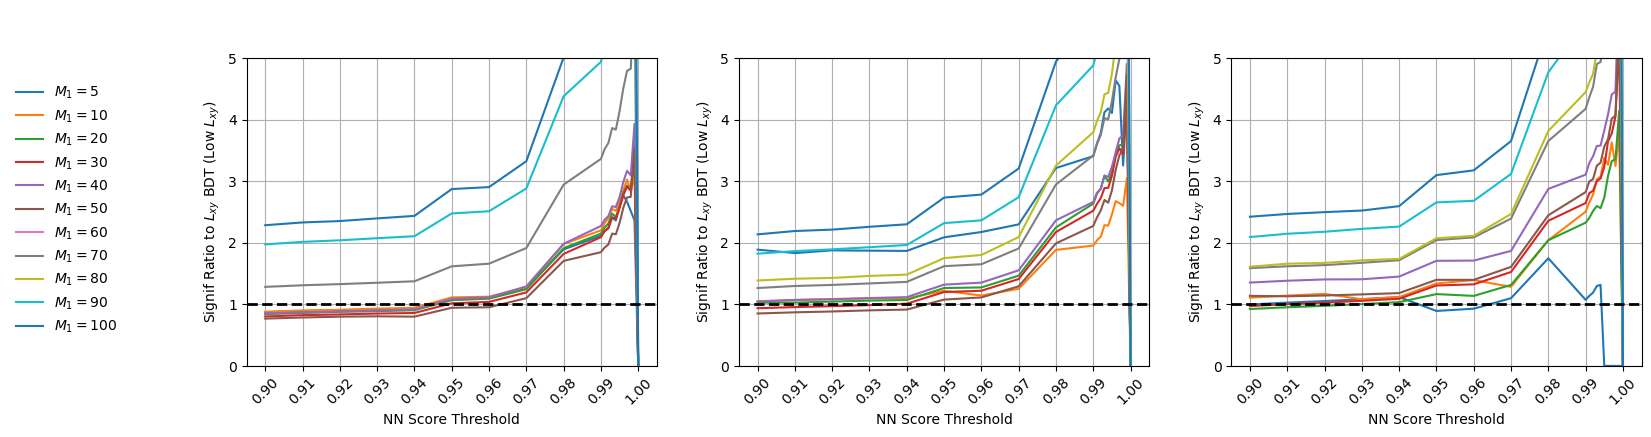

In [14]:
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_lowLxy[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields_lowLxy),where=bkg_yields_lowLxy!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields_lowLxy == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields_lowLxy == 0)] = np.inf
            
            signif_bdt = bdt_yields_sig_lowLxy[sampName]/np.sqrt(bdt_yield_bkg_lowLxy)
            if signif_bdt == 0:
                signif_ratio = np.where(signif!=0,np.inf,0)
            else:
                signif_ratio = np.divide(signif,signif_bdt)
            plt.plot(thresholds,signif_ratio,color=massColors[m1])
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Signif Ratio to $L_{xy}$ BDT (Low $L_{xy}$)")
        plt.axhline(1,lw=2,color='black',linestyle='--')
        #plt.yscale('log')
        plt.ylim([0,5])
        plt.yticks(np.arange(6))
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        plt.grid(axis='both')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

## NN vs BDT event yields

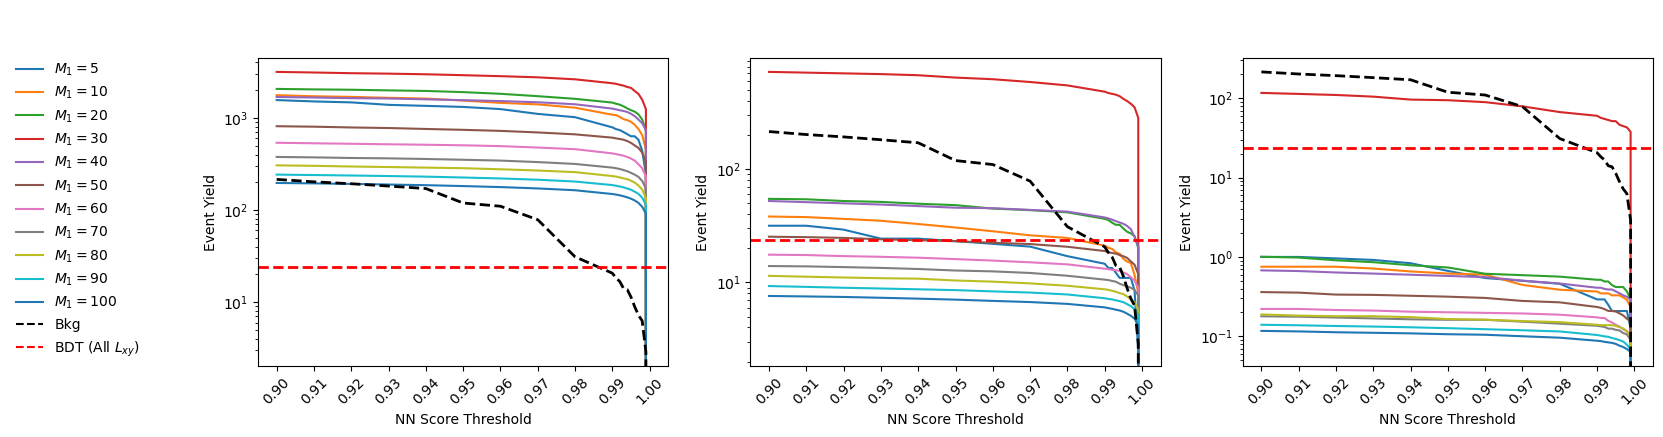

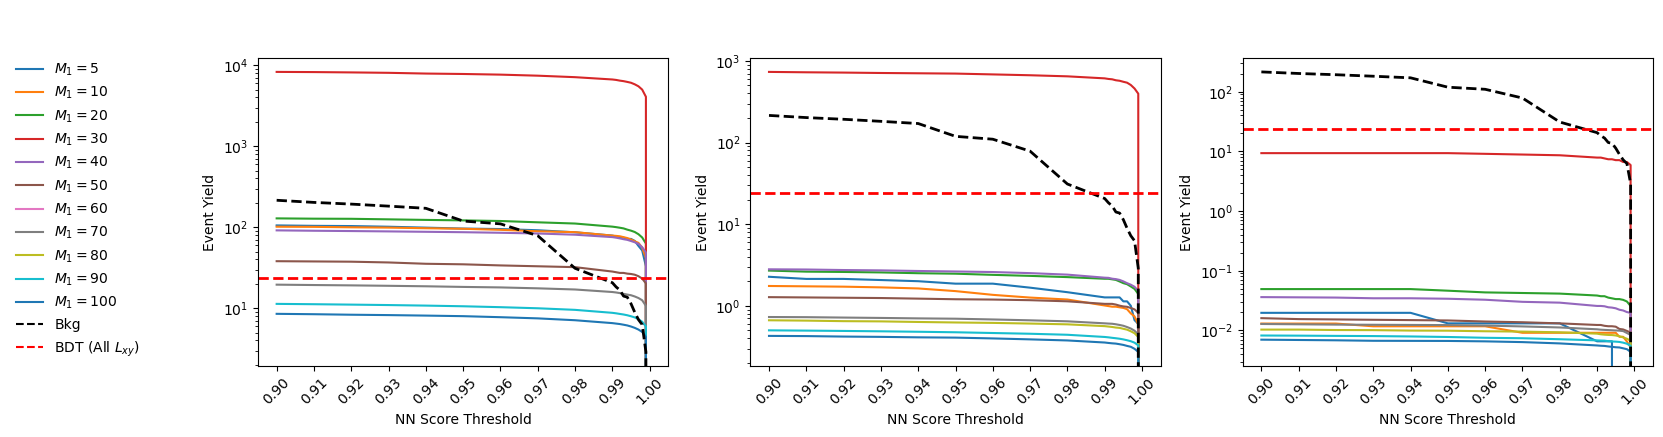

In [15]:
# plot event yields
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_lowLxy[sampName]
            plt.plot(thresholds,y_sig,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.plot(thresholds,bkg_yields_lowLxy,color='black',lw=2,linestyle='--')
        plt.axhline(bdt_yield_bkg_lowLxy,color='red',lw=2,linestyle='--')
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Event Yield")
        plt.yscale('log')
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        
            
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))] + \
                 [Line2D([0], [0], label=f"Bkg", color='black',linestyle='--'), Line2D([0], [0], label="BDT (All $L_{xy}$)", color='red',linestyle='--')]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

# High $L_{xy}$ bin ($L_{xy} > 0.5$ cm)

In [16]:
bkg_yields_highLxy = yieldScan(dfb[dfb.vxy > 0.5],thresholds)
sig_yields_highLxy = {}
for samp in sigNames:
    sig_yields_highLxy[samp] = yieldScan(dfs[(dfs.samp==samp)&(dfs.vxy > 0.5)],thresholds)

## NN significance

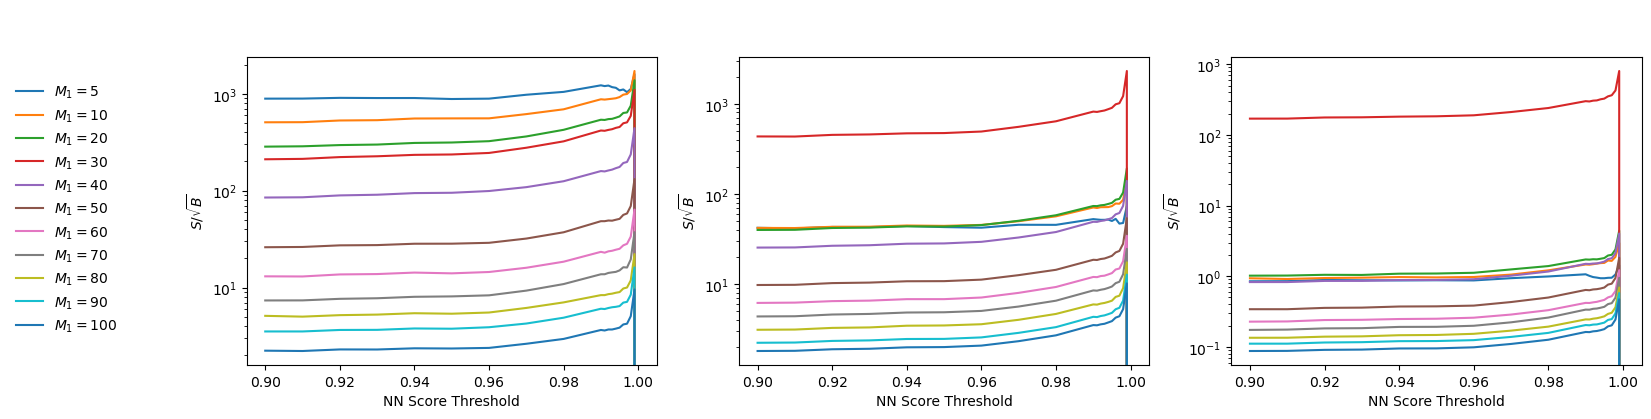

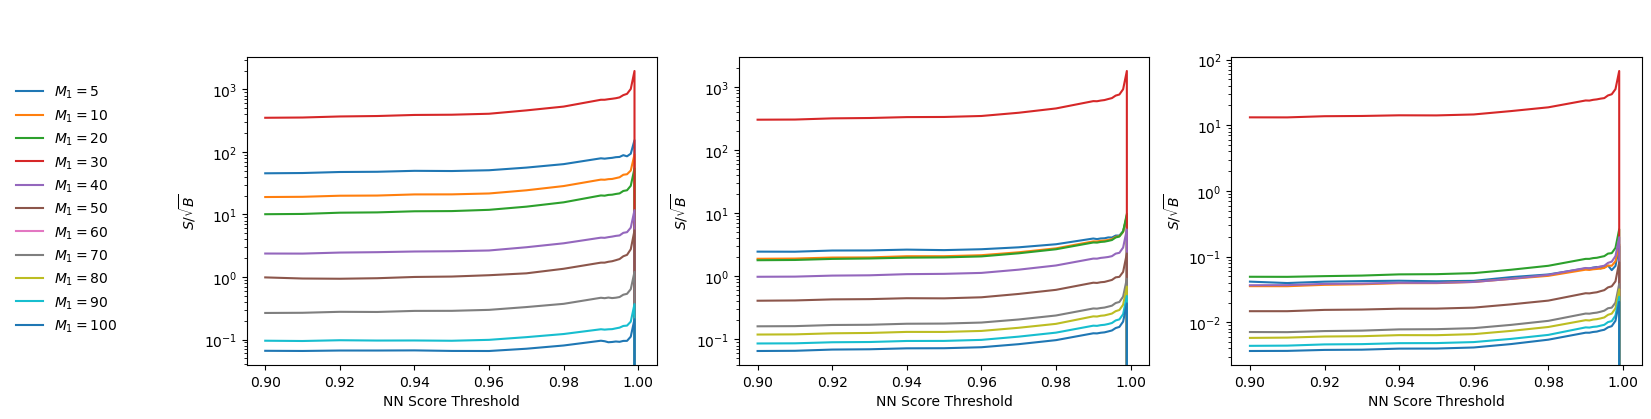

In [17]:
# plot signal significance
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_highLxy[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields_highLxy),where=bkg_yields_highLxy!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields_highLxy == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields_highLxy == 0)] = np.inf
            plt.plot(thresholds,signif,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.xlabel("NN Score Threshold")
        plt.ylabel("$S/\sqrt{B}$")
        plt.yscale('log')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

In [18]:
prefix = "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/studies/SR_BDT/BDT_Lxy/coffea/skimmed/"
suffix = '_LxyBDT-based_HighLxy'

bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}
bkg_histos_highLxy = {}
for b in bkg_files.keys():
    bkg_histos_highLxy[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]

sig_histo_highLxy = util.load(f'{prefix}/LxyBDT-based_HighLxy.coffea')[0]

In [19]:
cut = 'cut11'
bdt_yield_bkg_highLxy = 0
for b in bkg_histos_highLxy.keys():
    cb = bkg_histos_highLxy[b]['cutflow_cts']
    for b2 in cb.keys():
        bdt_yield_bkg_highLxy += cb[b2][cut]

bdt_yields_sig_highLxy = {}
for samp in sigNames:
    bdt_yields_sig_highLxy[samp] = sig_histo_highLxy['cutflow_cts'][samp][cut]

## NN vs BDT significance

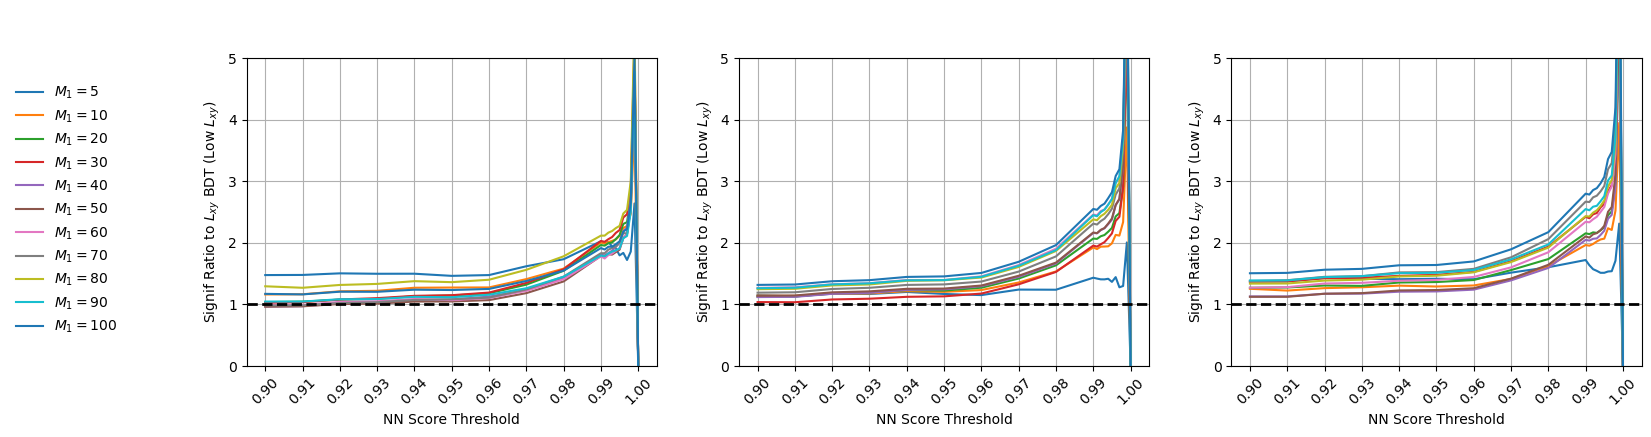

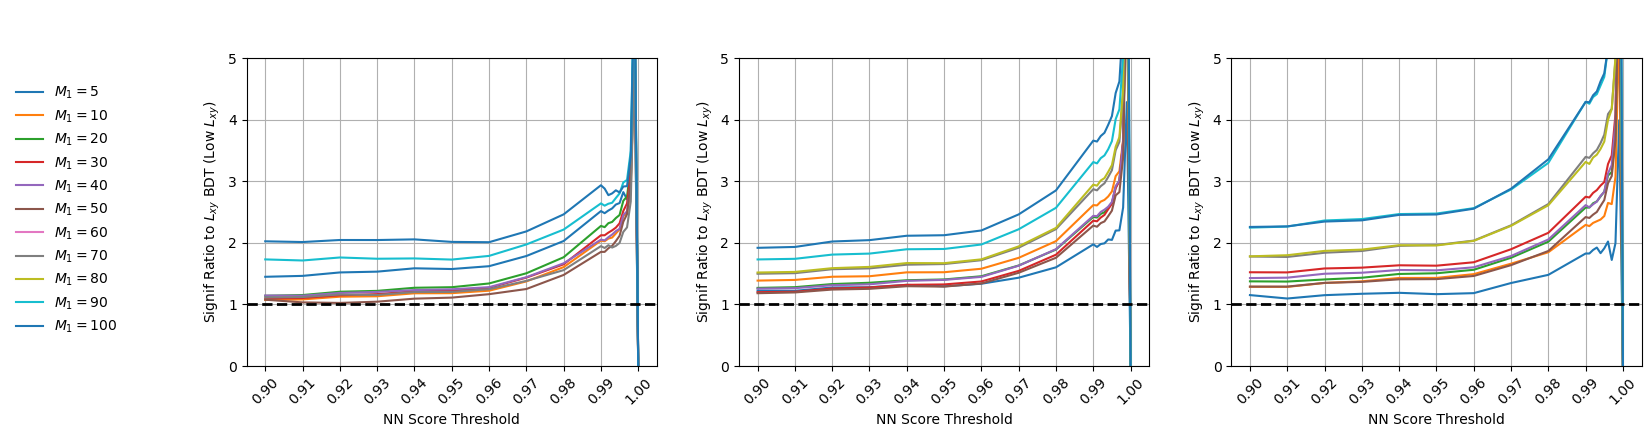

In [20]:
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_highLxy[sampName]
            signif = np.divide(y_sig,np.sqrt(bkg_yields_highLxy),where=bkg_yields_highLxy!=0,out=-1*np.ones_like(y_sig))
            signif[(y_sig == 0) & (bkg_yields_highLxy == 0)] = 0
            signif[(y_sig != 0) & (bkg_yields_highLxy == 0)] = np.inf
            
            signif_bdt = bdt_yields_sig_highLxy[sampName]/np.sqrt(bdt_yield_bkg_highLxy)
            if signif_bdt == 0:
                signif_ratio = np.where(signif!=0,np.inf,0)
            else:
                signif_ratio = np.divide(signif,signif_bdt)
            plt.plot(thresholds,signif_ratio,color=massColors[m1])
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Signif Ratio to $L_{xy}$ BDT (Low $L_{xy}$)")
        plt.axhline(1,lw=2,color='black',linestyle='--')
        #plt.yscale('log')
        plt.ylim([0,5])
        plt.yticks(np.arange(6))
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        plt.grid(axis='both')
        
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

## NN vs BDT event yields

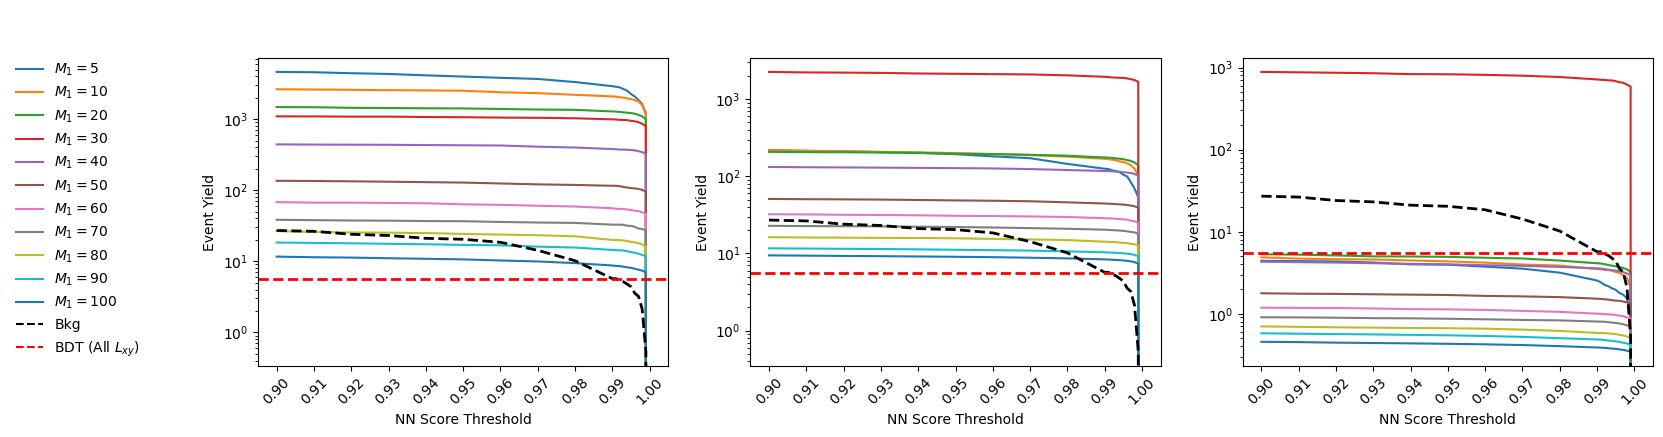

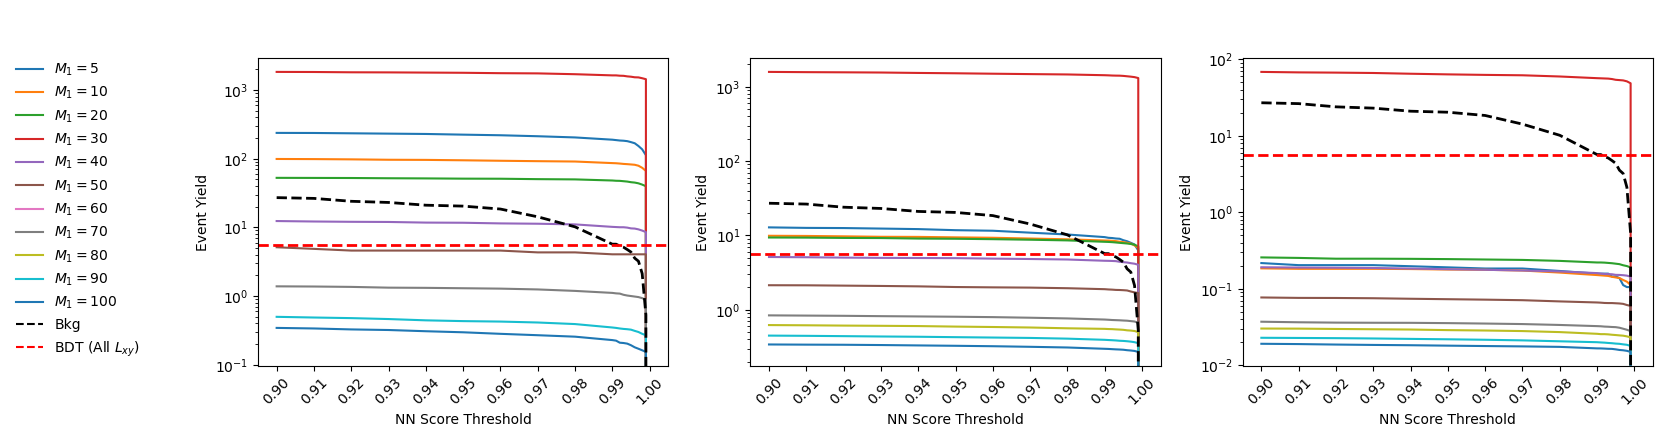

In [21]:
# plot event yields
allMasses = [5,10,20,30,40,50,60,70,80,90,100]
massColors = {allMasses[i]:f"C{i}" for i in range(len(allMasses))}

deltas = sorted(list(set(dfs.delta)))
ctaus = [1,10,100]
for d in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    for i,ct in enumerate(ctaus):
        plt.sca(axes[i])
        m1s = sorted(list(set(dfs[(dfs.delta==d)&(dfs.ctau==ct)].m1)))
        for m1 in m1s:
            sampName = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].samp.to_list()[0]
            y_sig = sig_yields_highLxy[sampName]
            plt.plot(thresholds,y_sig,color=massColors[m1],label=f"$M_1 = {m1}$")
        plt.plot(thresholds,bkg_yields_highLxy,color='black',lw=2,linestyle='--')
        plt.axhline(bdt_yield_bkg_highLxy,color='red',lw=2,linestyle='--')
        plt.xlabel("NN Score Threshold")
        plt.ylabel("Event Yield")
        plt.yscale('log')
        plt.xticks(np.arange(0.9,1.01,0.01),rotation=45)
        
            
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$", color=massColors[m]) for m in sorted(list(massColors.keys()))] + \
                 [Line2D([0], [0], label=f"Bkg", color='black',linestyle='--'), Line2D([0], [0], label="BDT (All $L_{xy}$)", color='red',linestyle='--')]
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)
    #fig.tight_layout()

# Tables

In [ ]:
mass_df = []
delta_df = []
ctau_df = []
signif_bdt_df = []
signif_nn_df = []
for samp in sigNames:
    mass_df.append(dfs[dfs.samp==samp].m1.to_list()[0])
    delta_df.append(dfs[dfs.samp==samp].delta.to_list()[0])
    ctau_df.append([dfs.samp==samp].ctau.to_list()[0])
    signif_bdt_df.append(